In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from spellchecker import SpellChecker
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import torch
from transformers import BertTokenizer, BertModel

# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
warnings.filterwarnings("ignore")

In [2]:
class CategoriesClassifier:
    def __init__(self, df_train, df_test, df_val, verbose=True):
        self.df_train = df_train.copy()
        self.df_test = df_test.copy()
        self.df_val = df_val.copy()
        self.feature_name = 'CompleteText'
        self.verbose = verbose
        self.data_type = {
            'train': self.df_train,
            'val': self.df_val,
            'test': self.df_test,
        }
        self.bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        if self.verbose: display(self.df_train.info())
        
    def transform_text(self, text):
        # Lowercasing
        text = text.lower()
        # Removing urls
        url_pattern = re.compile(r'https?://\S+|www\.\S+')
        text = url_pattern.sub('', text)
        # Removing special characters, punctuations, emojis and symbols
        text = re.sub(r'[^\w\s\d]|[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00026000-\U00026FFF]', '', text)
        # Removing email address 
        text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)
        # Removing newline
        text = text.replace('\n', ' ')
        # Removing hashtags
        text = re.sub(r'@\w+|#\w+', '', text)
        # Removing whitespace and extra spaces
        text = ' '.join(text.split())
        # Removing stopwords
        tokens = word_tokenize(text)
        filtered_tokens = [word for word in tokens if word not in stop_words]
        # lemmatization
        lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
        text = ' '.join(lemmatized_tokens)
        return text
    
    def preprocess_text(self, cols):
        for k, v in self.data_type.items():
            if self.verbose: print(f'Preprocessing-- {k} data')
            v[self.feature_name] = v[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1).apply(self.transform_text)
                
    def get_bert_embeddings(self, data):
        if self.verbose: print(f'Processing {data} data')
        df = self.data_type.get(data)
        features = df[self.feature_name].tolist()
        max_length = 128 
        # Tokenize and convert to tensor
        inputs = self.bert_tokenizer(features, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
        # Get BERT embeddings
        with torch.no_grad():
            outputs = self.bert_model(**inputs)
        # Use the [CLS] token embedding as the representation for the entire input
        embeddings = outputs.last_hidden_state[:, 0, :].numpy()
        return embeddings
    
    def covert_to_tfidf_vector(self):
        self.tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 2), stop_words='english')
        self.X_train = self.tfidf_vectorizer.fit_transform(self.df_train[self.feature_name]).toarray()
        self.X_val = self.tfidf_vectorizer.transform(self.df_val[self.feature_name]).toarray()
        self.X_test = self.tfidf_vectorizer.transform(self.df_test[self.feature_name]).toarray()
          
    def multioutput_accuracy(self, y_true, y_pred):
        num_outputs = y_true.shape[1]
        accuracies = []
        for i in range(num_outputs):
            accuracy = accuracy_score(y_true[:, i], y_pred[:, i])
            accuracies.append(accuracy)
        # Overall accuracy is the average of accuracies for all outputs
        overall_accuracy = sum(accuracies) / num_outputs
        return overall_accuracy
    
    def feature_extraction(self, kind='tfidf'):
        if self.verbose: print('\nFeature Extraction')
        # Target encoding
        self.target_encoding = {
            'lvl1': {v: i for i, v in enumerate(self.df_train['lvl1'].unique())},
            'lvl2': {v: i for i, v in enumerate(self.df_train['lvl2'].unique())},
            'lvl3': {v: i for i, v in enumerate(self.df_train['lvl3'].unique())}
        }
        
        if self.verbose: print(f'Performing Text Embedding using {kind}')
            
        if kind == 'bert':
            self.X_train = self.get_bert_embeddings('train')
            self.X_val = self.get_bert_embeddings('val')
            self.X_test = self.get_bert_embeddings('test')
        else:
            self.covert_to_tfidf_vector()

        if self.verbose: print(f'Encoding Target Labels')
        # Target encoding for y values
        self.y_train_lvl1 = self.df_train['lvl1'].map(self.target_encoding.get('lvl1')).values
        self.y_train_lvl2 = self.df_train['lvl2'].map(self.target_encoding.get('lvl2')).values
        self.y_train_lvl3 = self.df_train['lvl3'].map(self.target_encoding.get('lvl3')).values
        self.y_val_lvl1 = self.df_val['lvl1'].map(self.target_encoding.get('lvl1')).values
        self.y_val_lvl2 = self.df_val['lvl2'].map(self.target_encoding.get('lvl2')).values
        self.y_val_lvl3 = self.df_val['lvl3'].map(self.target_encoding.get('lvl3')).values

        # Stack them horizontally to create y_train and y_val
        self.y_train = np.column_stack((self.y_train_lvl1, self.y_train_lvl2, self.y_train_lvl3))
        self.y_val = np.column_stack((self.y_val_lvl1, self.y_val_lvl2, self.y_val_lvl3))
        
        if self.verbose: print(f'Training: {self.X_train.shape=}, {self.y_train.shape}')
        if self.verbose: print(f'Validation: {self.X_val.shape=}, {self.y_val.shape}')
        if self.verbose: print(f'Testing: {self.X_test.shape=}')
            
        
    def train_evaluate_ml_models(self, models, param_grids):
        # Train and evaluate each model
        self.models = {}
        self.accuracies = {}

        for model_name, model in models.items():
            if self.verbose: print(f"\nTraining and evaluating {model_name}...")
            param_grid = param_grids[model_name]
            multi_output_model = MultiOutputClassifier(model)
            grid_search = GridSearchCV(multi_output_model, param_grid, cv=3, n_jobs=-1)
            grid_search.fit(self.X_train, self.y_train)

            # Saving the best model
            self.models[model_name] = grid_search.best_estimator_

            # Predicting on train and validation sets
            y_train_pred = grid_search.predict(self.X_train)
            y_val_pred = grid_search.predict(self.X_val)
            

            # Calculate accuracy for train and validation sets
            train_accuracy = self.multioutput_accuracy(self.y_train, y_train_pred)
            val_accuracy = self.multioutput_accuracy(self.y_val, y_val_pred)

            self.accuracies[model_name] = {'train_accuracy': train_accuracy, 'val_accuracy': val_accuracy}

            if self.verbose: print(f"Best parameters for {model_name}: {grid_search.best_params_}")
            if self.verbose: print(f"Train accuracy for {model_name}: {train_accuracy}")
            if self.verbose: print(f"Validation accuracy for {model_name}: {val_accuracy}\n\n")
    
    def fit_best_model(self, criteria='val_accuracy'):
        self.finalized_model = self.models.get(max(self.accuracies, key=lambda k: self.accuracies[k][criteria]))
        if self.verbose: print(f'\nTraining Best model i-e {self.finalized_model}')
        self.finalized_model.fit(self.X_train, self.y_train)
        
        # Predicting on train and validation sets
        self.y_train_pred = self.finalized_model.predict(self.X_train)
        self.y_val_pred = self.finalized_model.predict(self.X_val)

        # Calculate accuracy for train and validation sets
        train_accuracy = self.multioutput_accuracy(self.y_train, self.y_train_pred)
        val_accuracy = self.multioutput_accuracy(self.y_val, self.y_val_pred)
        
        if self.verbose: print(f"Training accuracy {train_accuracy}, Validation accuracy {val_accuracy}")
            
    def test_best_model(self):
        if self.verbose: print(f'\nTesting Best model i-e {self.finalized_model} on Testing data')
        self.y_test_pred = self.finalized_model.predict(self.X_test)
        
    def decode_and_assign_predictions(self):
        if self.verbose: print(f'Adding predictions on dataframes')
        for level in self.target_encoding.keys():
            self.df_train[f'{level}_pred'] = [list(self.target_encoding[level].keys())[list(self.target_encoding[level].values()).index(pred[0])] for pred in self.y_train_pred]
            self.df_val[f'{level}_pred'] = [list(self.target_encoding[level].keys())[list(self.target_encoding[level].values()).index(pred[0])] for pred in self.y_val_pred]
            self.df_test[f'{level}_pred'] = [list(self.target_encoding[level].keys())[list(self.target_encoding[level].values()).index(pred[0])] for pred in self.y_test_pred]
        if self.verbose: display(self.df_train.head(10), self.df_val.head(10), self.df_test.head(10))
            
    def visualize_all_models(self):
        # Extract training and validation accuracies
        train_accuracies = [self.accuracies[model]['train_accuracy'] for model in self.accuracies.keys()]
        val_accuracies = [self.accuracies[model]['val_accuracy'] for model in self.accuracies.keys()]

        # Plotting the bar chart
        x = range(len(models))
        width = 0.35

        plt.bar(x, train_accuracies, width, label='Train Accuracy')
        plt.bar([p + width for p in x], val_accuracies, width, label='Validation Accuracy')

        plt.xlabel('Models')
        plt.ylabel('Accuracy')
        plt.title('Train and Validation Accuracy for Different Models')
        plt.xticks([p + width/2 for p in x], models)
        plt.legend()
        plt.show()
    
    def visualize_top_categories(self, data, level=None, top_n=10):
        df = self.data_type.get(data)
        if level:
            top_categories = df[level].value_counts().nlargest(top_n)
        else:
            top_categories = df[['lvl1', 'lvl2', 'lvl3']].apply(lambda row: ' > '.join(row.values.astype(str)), axis=1).value_counts().nlargest(top_n)
        plt.figure(figsize=(12, 6))
        sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
        plt.title(f'Top {top_n} Categories in {level}')
        plt.xlabel('Number of Products')
        plt.ylabel('Category')
        plt.show()
        
        
    def visualize_wordcloud(self, data):
        df = self.data_type.get(data)
        all_descriptions = ' '.join(df[self.feature_name])
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_descriptions)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of Product Descriptions\n')
        plt.show()
        
    def visualize_text_length(self, data):
        df = self.data_type.get(data)
        df['Text_Length'] = df[self.feature_name].apply(len)
        plt.figure(figsize=(10, 5))
        sns.histplot(df['Text_Length'], bins=20, kde=True)
        plt.xlabel('Text Length')
        plt.ylabel('Count')
        plt.title('Text Length Distribution')
        plt.show()
        
    def visualize_classification_report(self, data):
        types = {
            'train': {'true': self.y_train, 'pred': self.y_train_pred},
            'val': {'true': self.y_val, 'pred': self.y_val_pred}
        }
        y_true = types.get(data, {}).get('true')
        y_pred = types.get(data, {}).get('pred')
        labels = list(self.target_encoding.keys())

        fig, axes = plt.subplots(1, len(labels), figsize=(6 * len(labels), 4))

        for label_col in range(len(labels)):
            y_true_label = y_true[:, label_col]
            y_pred_label = y_pred[:, label_col]

            # Generate classification report
            class_report = classification_report(y_true_label, y_pred_label,
                                                 labels=np.unique(y_true_label), target_names=[f'{labels[label_col]}'],
                                                 output_dict=True)

            print(labels[label_col])
            display(pd.DataFrame(class_report))
            # Extract metrics
            metrics = {
                'Precision': class_report[f'{labels[label_col]}']['precision'],
                'Recall': class_report[f'{labels[label_col]}']['recall'],
                'F1-Score': class_report[f'{labels[label_col]}']['f1-score']
            }

            # Plot metrics
            ax = axes[label_col]
            ax.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'orange'])
            ax.set_ylabel('Score')
            ax.set_title(f'Metrics for label {labels[label_col]}')
        plt.tight_layout()
        plt.show()
        
    def visualize_top_predicted_categories(self, data, n=5, kind='best'):
        df = self.data_type.get(data).copy()
        df['target'] = df[self.target_encoding.keys()].apply(lambda row: ' > '.join(row.values.astype(str)), axis=1)
        df['true_prediction'] = (df['lvl1'].eq(df['lvl1_pred']) & df['lvl2'].eq(df['lvl2_pred']) & df['lvl3'].eq(df['lvl3_pred'])).astype(int)
        pct_true_prediction = df.groupby('target')['true_prediction'].mean().mul(100)
        
        if kind == 'worst':
            result = pct_true_prediction.nsmallest(n)
        else:
            result = pct_true_prediction.nlargest(n)

        plt.figure(figsize=(10, 6))
        result.plot(kind='barh')
        plt.xlabel('Accuracy')
        plt.ylabel('Category')
        plt.title(f'Top {n} {kind} Predicted Categories')
        plt.show()

In [3]:
df_train = pd.read_json('Data/train_data.json', lines=True)
df_test = pd.read_json('Data/test_data.json', lines=True)
df_val = pd.read_json('Data/validation_data.json', lines=True)

In [4]:
cls = CategoriesClassifier(df_train, df_test, df_val)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10012 entries, 0 to 10011
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            10012 non-null  int64 
 1   Name          10012 non-null  object
 2   Description   10012 non-null  object
 3   CategoryText  10012 non-null  object
 4   URL           10012 non-null  object
 5   lvl1          10012 non-null  object
 6   lvl2          10012 non-null  object
 7   lvl3          10012 non-null  object
dtypes: int64(1), object(7)
memory usage: 625.9+ KB


None

# Preprocessing CategoryText, Name, Description

In [5]:
cls.preprocess_text(cols=['CategoryText', 'Name', 'Description'])

Preprocessing-- train data
Preprocessing-- val data
Preprocessing-- test data


# EDA

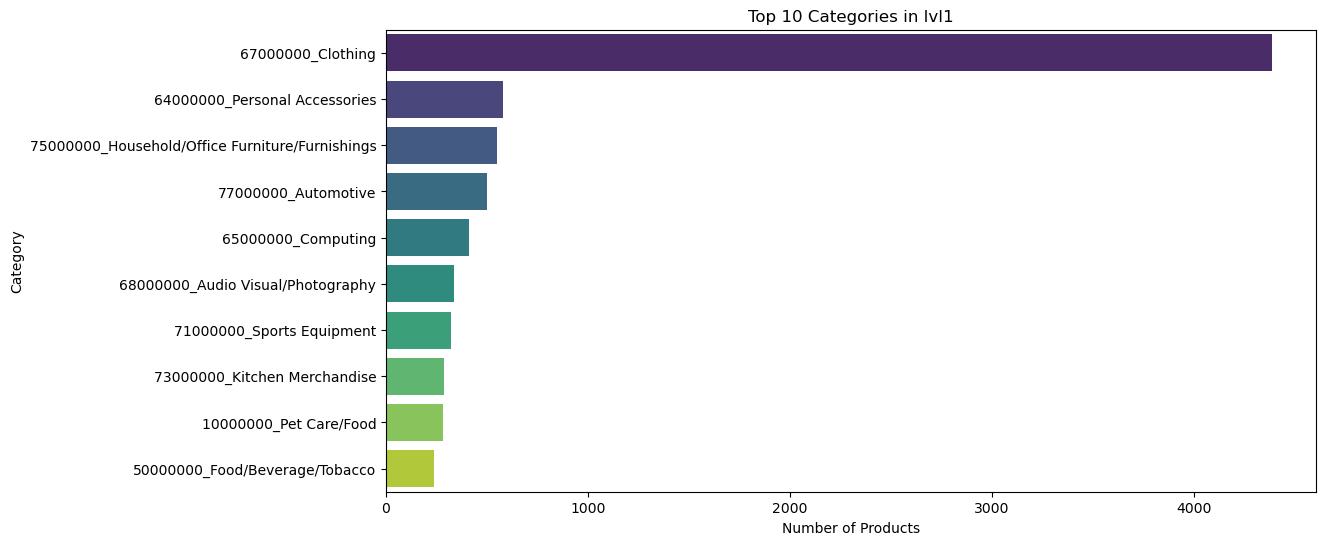

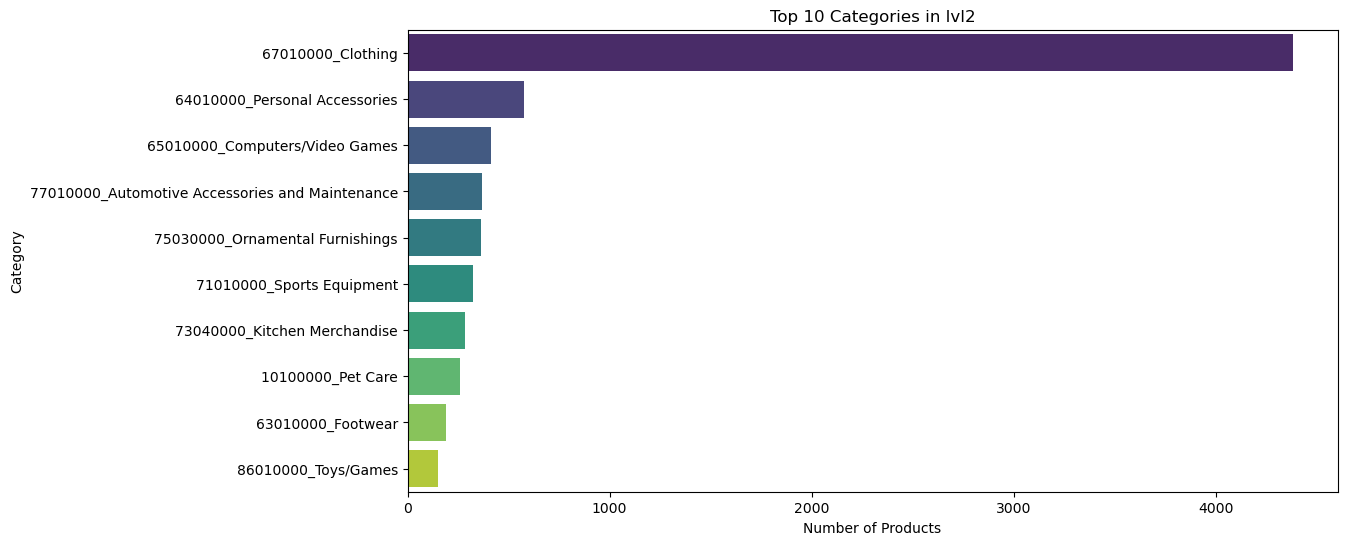

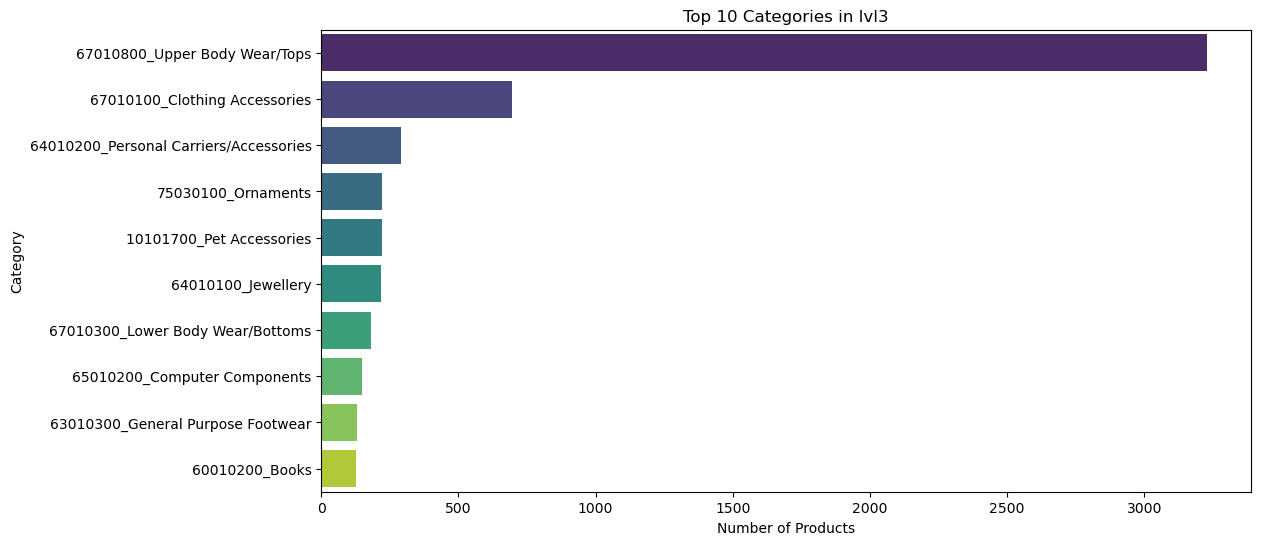

In [6]:
cls.visualize_top_categories(data='train', level='lvl1', top_n=10)
cls.visualize_top_categories(data='train', level='lvl2', top_n=10)
cls.visualize_top_categories(data='train', level='lvl3', top_n=10)

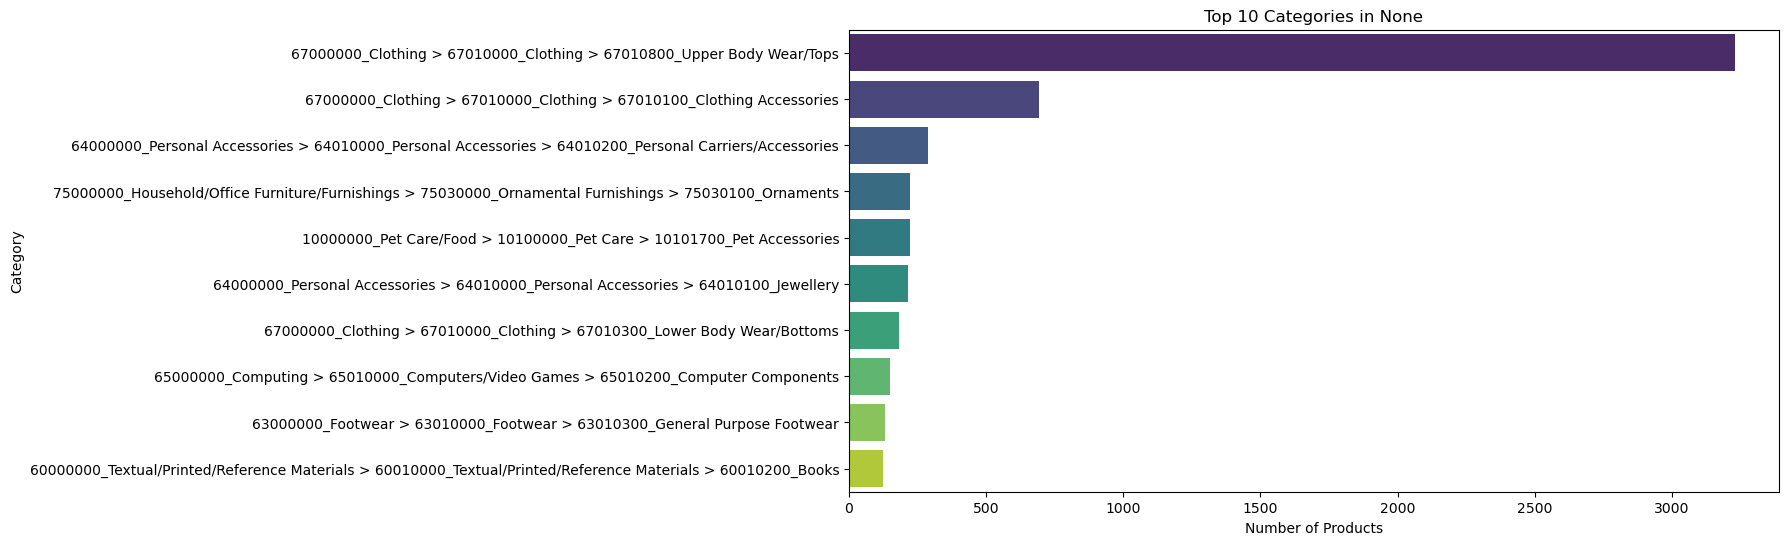

In [7]:
cls.visualize_top_categories(data='train', level=None, top_n=10)

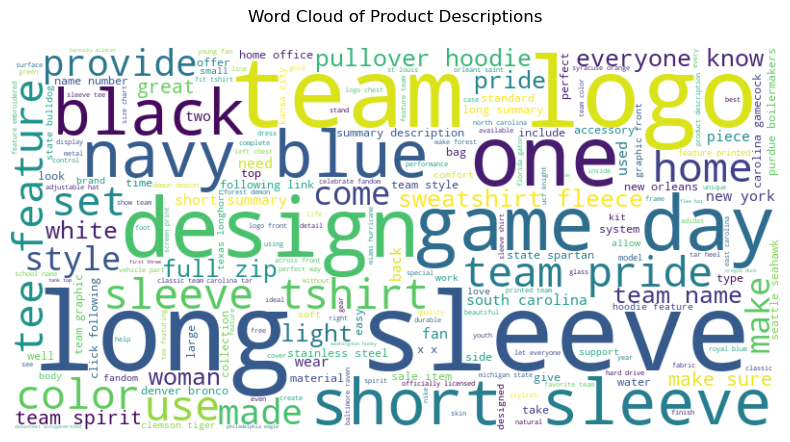

In [8]:
cls.visualize_wordcloud(data='train')

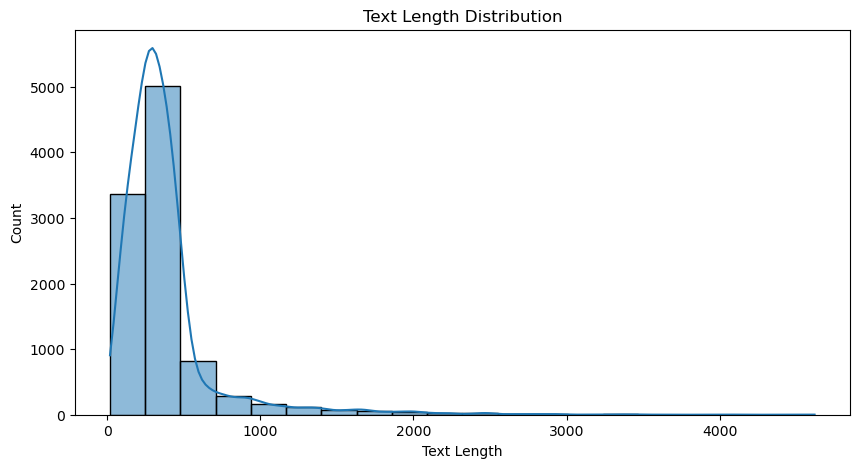

In [9]:
cls.visualize_text_length(data='train')

# Feature Extraction Using TF-IDF AND BERT

In [10]:
# cls.feature_extraction(kind='bert')
cls.feature_extraction(kind='tfidf')


Feature Extraction
Performing Text Embedding using tfidf
Encoding Target Labels
Training: self.X_train.shape=(10012, 16415), (10012, 3)
Validation: self.X_val.shape=(3000, 16415), (3000, 3)
Testing: self.X_test.shape=(3107, 16415)


# Getting Best model with optimal hyperparameters

In [ ]:
# models to evaluate
models = {
#     'SVM': SVC(),
    'RandomForest': RandomForestClassifier(),
    'KNeighbors': KNeighborsClassifier()
}

# Parameter grids for grid search
param_grids = {
    'SVM': {'estimator__C': [0.001, 1, 10], 'estimator__class_weight': ['balanced']},
    'RandomForest': {'estimator__n_estimators': [4, 10, 20], 'estimator__class_weight': ['balanced']},
    'KNeighbors': {'estimator__n_neighbors': [3, 5, 10]}
}

cls.train_evaluate_ml_models(models, param_grids)


Training and evaluating RandomForest...


In [ ]:
cls.visualize_all_models()

# Training the best model

In [ ]:
cls.fit_best_model(criteria='val_accuracy')
cls.test_best_model()

In [ ]:
cls.decode_and_assign_predictions()

# Model Evaluation

In [ ]:
cls.visualize_classification_report(data='train')

In [ ]:
cls.visualize_classification_report(data='val')

In [ ]:
cls.visualize_top_predicted_categories(data='val', n=5, kind='best')

In [ ]:
cls.visualize_top_predicted_categories(data='val', n=5, kind='worst')